In [1]:
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import GlobalAveragePooling2D, Reshape, multiply
from keras.applications.vgg16 import preprocess_input
from keras.models import Model
from keras.layers.core import Lambda
from keras.utils.vis_utils import plot_model
from tensorflow.python.framework import ops
from tensorflow.keras.layers import GlobalMaxPooling2D, GlobalAveragePooling2D, Dropout, Dense, Input, Conv2D, MaxPooling2D, Flatten,MaxPooling3D

import keras.backend as K
from keras import optimizers
import random
import sys
import cv2
import os
from skimage import io
import tensorflow as tf
import numpy as np
from keras.models import load_model
from keras import initializers
from keras.callbacks import ModelCheckpoint, EarlyStopping

import csv
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

category_num=3
os.environ["CUDA_VISIBLE_DEVICES"] = "1" 
config = tf.compat.v1.ConfigProto(log_device_placement=True,
inter_op_parallelism_threads=0,
intra_op_parallelism_threads=0,
allow_soft_placement=True)
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config = config)

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:b3:00.0, compute capability: 6.1



Number of images in train set :  2993
Number of images in test set :  643
Number of images in val set :  642


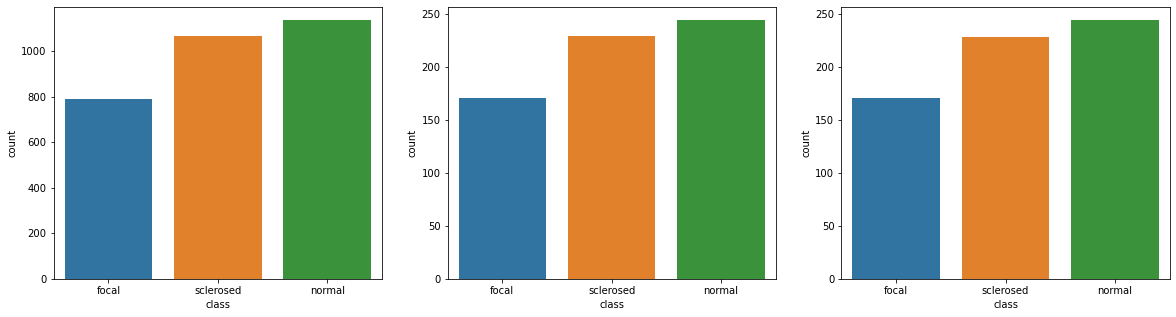

In [2]:
root_path = '/media/ai1/1337af50-4ca0-4065-8fbe-0e8c353e7de8/Fauzan_Research/glomeruli dataset/auto_split/'
train_pred_test_folders = os.listdir(root_path)

train_folders = '/media/ai1/1337af50-4ca0-4065-8fbe-0e8c353e7de8/Fauzan_Research/glomeruli dataset/auto_split/train/' #one more seg_train folder within
test_folders = '/media/ai1/1337af50-4ca0-4065-8fbe-0e8c353e7de8/Fauzan_Research/glomeruli dataset/auto_split/test/'
val_folders = '/media/ai1/1337af50-4ca0-4065-8fbe-0e8c353e7de8/Fauzan_Research/glomeruli dataset/auto_split/val/'
quantity_tr = {} 
quantity_te = {}
quantity_va = {}
for folder in os.listdir(train_folders):
    quantity_tr[folder] = len(os.listdir(train_folders+folder))

for folder in os.listdir(test_folders):
    quantity_te[folder] = len(os.listdir(test_folders+folder))

for folder in os.listdir(val_folders):
    quantity_va[folder] = len(os.listdir(val_folders+folder))

quantity_train = pd.DataFrame(list(quantity_tr.items()), index=range(0,len(quantity_tr)), columns=['class','count'])
quantity_test = pd.DataFrame(list(quantity_te.items()), index=range(0,len(quantity_te)), columns=['class','count'])
quantity_val = pd.DataFrame(list(quantity_va.items()), index=range(0,len(quantity_va)), columns=['class','count'])

figure, ax = plt.subplots(1,3,figsize=(20,5))
sns.barplot(x='class',y='count',data=quantity_train,ax=ax[0])
sns.barplot(x='class',y='count',data=quantity_test,ax=ax[1])
sns.barplot(x='class',y='count',data=quantity_val,ax=ax[2])
#sns.barplot(x='class',y='count',data=quantity_new_data,ax=ax[3])

print("Number of images in train set : ", sum(quantity_tr.values()))
print("Number of images in test set : ",sum(quantity_te.values()))
#number_of_images_in_prediction_set = len(os.listdir(seg_pred_folders))
print("Number of images in val set : ",sum(quantity_va.values()))
#print("Number of images in new dataset : ",sum(quantity_ne.values()))

plt.show()

In [3]:
IMG_SIZE = 256

In [4]:
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')
validation_datagen = ImageDataGenerator(preprocessing_function= preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function= preprocess_input)

In [5]:
def train(BATCH_SIZE):
    train_generator = train_datagen.flow_from_directory(train_folders,
                                                        batch_size=BATCH_SIZE,
                                                        class_mode='categorical',
                                                        target_size=(IMG_SIZE, IMG_SIZE))
    return train_generator

In [6]:
def validation(BATCH_SIZE):
    
    validation_generator = validation_datagen.flow_from_directory(val_folders, 
                                                                  batch_size=BATCH_SIZE, 
                                                                  class_mode='categorical', 
                                                                  target_size=(IMG_SIZE, IMG_SIZE))
    return validation_generator

In [7]:
def test(BATCH_SIZE):
    test_generator = test_datagen.flow_from_directory(test_folders,
                                                      batch_size=BATCH_SIZE,
                                                      class_mode='categorical',
                                                      target_size=(IMG_SIZE, IMG_SIZE))
    return test_generator

In [8]:
def show_few_images(number_of_examples, predict_using_model):
    figure1, ax1 = plt.subplots(number_of_examples,len(os.listdir(train_folders)), figsize=(20,4*number_of_examples))
    ax1 = ax1.reshape(-1)
    axoff_fun = np.vectorize(lambda ax:ax.axis('off'))
    axoff_fun(ax1)
    axs = 0
    for i, folder in enumerate(os.listdir(train_folders)):
        image_ids = os.listdir(os.path.join(train_folders,folder))
        for j in [random.randrange(0, len(image_ids)) for i in range(0,number_of_examples)]:
            path = os.path.join(train_folders,folder,image_ids[j])
            display = cv2.resize(cv2.imread(path),(IMG_SIZE,IMG_SIZE))
            display = display/IMG_SIZE
            
            plt.axis('off')
            ax1[axs].imshow(display)
            title = 'True:'+folder
            if(predict_using_model):
                predicted_classname = inv_map_classes[np.argmax(predict_using_model.predict(np.array([display])))]
                title = title+'\nPredict :'+predicted_classname
            ax1[axs].set_title(title)
            axs=axs+1

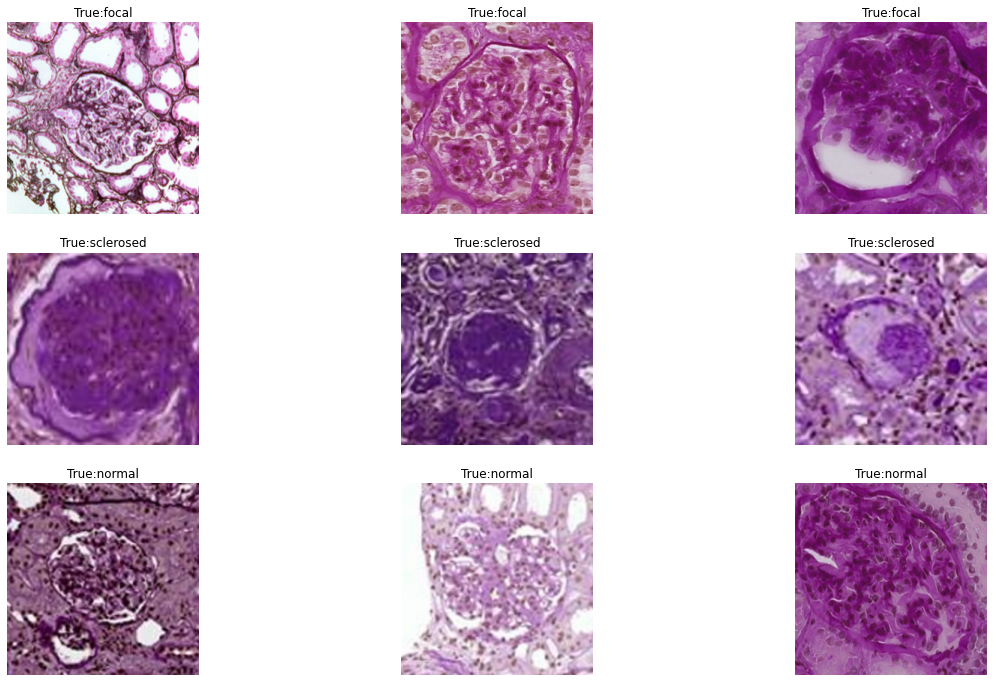

In [9]:
show_few_images(3,None)

In [10]:
with tf.device("/gpu:1"):
    model = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(IMG_SIZE,IMG_SIZE,3))
    for layers in model.layers:
        layers.trainable=False
    last_output = model.layers[-1].output
    output = Flatten()(last_output)
    output = Dense(128, activation = 'relu')(output)
    output = Dense(3, activation = 'softmax')(output)
    model = Model(model.input, output)
    model.compile(loss = 'categorical_crossentropy', optimizer= 'adam', metrics=['acc'])

In [11]:
data_train = train(1)
data_validation = validation(1)
model.fit(
    data_train,
#    steps_per_epoch=2000,
    epochs=30,
    validation_data=data_validation,
    workers=10,
    shuffle = True,
    verbose=1)

Found 2993 images belonging to 3 classes.
Found 642 images belonging to 3 classes.
Epoch 1/30
2993/2993 [==============================] - 76s 22ms/step - loss: 14.6126 - acc: 0.5931 - val_loss: 0.4720 - val_acc: 0.7539
Epoch 2/30
2993/2993 [==============================] - 68s 23ms/step - loss: 0.5558 - acc: 0.7163 - val_loss: 0.5349 - val_acc: 0.7570
Epoch 3/30
2993/2993 [==============================] - 68s 23ms/step - loss: 0.6064 - acc: 0.7223 - val_loss: 0.4764 - val_acc: 0.7788
Epoch 4/30
2993/2993 [==============================] - 70s 23ms/step - loss: 0.5281 - acc: 0.7426 - val_loss: 0.4303 - val_acc: 0.7773
Epoch 5/30
2993/2993 [==============================] - 68s 23ms/step - loss: 0.5542 - acc: 0.7278 - val_loss: 0.5288 - val_acc: 0.7757
Epoch 6/30
2993/2993 [==============================] - 69s 23ms/step - loss: 0.5856 - acc: 0.7395 - val_loss: 0.4113 - val_acc: 0.7773
Epoch 7/30
2993/2993 [==============================] - 69s 23ms/step - loss: 0.4805 - acc: 0.7480 -

In [12]:
data_test = test(1)
model.evaluate(data_test)

Found 643 images belonging to 3 classes.
643/643 [==============================] - 9s 14ms/step - loss: 0.5397 - acc: 0.7714


[0.5396695733070374, 0.7713841199874878]

In [11]:
data_train = train(2)
data_validation = validation(2)
model.fit(
    data_train,
    validation_data = data_validation,
#    steps_per_epoch=2000,
    epochs=10,
    workers=8,
    shuffle = True,
    verbose=1)

Found 2993 images belonging to 3 classes.
Found 642 images belonging to 3 classes.
Epoch 1/10
1497/1497 [==============================] - 62s 36ms/step - loss: 10.2034 - acc: 0.6132 - val_loss: 0.5037 - val_acc: 0.7399
Epoch 2/10
1497/1497 [==============================] - 47s 31ms/step - loss: 0.6483 - acc: 0.7024 - val_loss: 0.4230 - val_acc: 0.7757
Epoch 3/10
1497/1497 [==============================] - 48s 32ms/step - loss: 0.5045 - acc: 0.7488 - val_loss: 0.4301 - val_acc: 0.7679
Epoch 4/10
1497/1497 [==============================] - 47s 31ms/step - loss: 0.5645 - acc: 0.7357 - val_loss: 0.4062 - val_acc: 0.7383
Epoch 5/10
1497/1497 [==============================] - 49s 32ms/step - loss: 0.5200 - acc: 0.7296 - val_loss: 0.4259 - val_acc: 0.7882
Epoch 6/10
1497/1497 [==============================] - 49s 33ms/step - loss: 0.5121 - acc: 0.7380 - val_loss: 0.4247 - val_acc: 0.7617
Epoch 7/10
1497/1497 [==============================] - 50s 33ms/step - loss: 0.5030 - acc: 0.7415 -

In [12]:
data_test = test(2)
model.evaluate(data_test)

Found 643 images belonging to 3 classes.
322/322 [==============================] - 8s 26ms/step - loss: 0.8479 - acc: 0.7341


[0.8479202389717102, 0.7340590953826904]

In [13]:
data_train = train(4)
data_validation = validation(4)
model.fit(
    data_train,
    validation_data = data_validation,
#    steps_per_epoch=2000,
    epochs=10,
    workers=8,
    shuffle = True,
    verbose=1)

Found 2993 images belonging to 3 classes.
Found 642 images belonging to 3 classes.
Epoch 1/10
749/749 [==============================] - 51s 59ms/step - loss: 0.4524 - acc: 0.7648 - val_loss: 0.4170 - val_acc: 0.7788
Epoch 2/10
749/749 [==============================] - 45s 60ms/step - loss: 0.4205 - acc: 0.7792 - val_loss: 0.3924 - val_acc: 0.7850
Epoch 3/10
749/749 [==============================] - 46s 61ms/step - loss: 0.4152 - acc: 0.7781 - val_loss: 0.4159 - val_acc: 0.7788
Epoch 4/10
749/749 [==============================] - 45s 60ms/step - loss: 0.4021 - acc: 0.7805 - val_loss: 0.3852 - val_acc: 0.7960
Epoch 5/10
749/749 [==============================] - 45s 60ms/step - loss: 0.3981 - acc: 0.7805 - val_loss: 0.3877 - val_acc: 0.7804
Epoch 6/10
749/749 [==============================] - 44s 58ms/step - loss: 0.4030 - acc: 0.7868 - val_loss: 0.4494 - val_acc: 0.7975
Epoch 7/10
749/749 [==============================] - 44s 58ms/step - loss: 0.4146 - acc: 0.7848 - val_loss: 0.39

In [14]:
data_test = test(4)
model.evaluate(data_test)

Found 643 images belonging to 3 classes.
161/161 [==============================] - 13s 80ms/step - loss: 0.4413 - acc: 0.7341


[0.44128620624542236, 0.7340590953826904]

In [15]:
data_train = train(8)
data_validation = validation(8)
model.fit(
    data_train,
    validation_data = data_validation,
#    steps_per_epoch=2000,
    epochs=10,
    workers=8,
    shuffle = True,
    verbose=1)

Found 2993 images belonging to 3 classes.
Found 642 images belonging to 3 classes.
Epoch 1/10
375/375 [==============================] - 50s 109ms/step - loss: 0.3856 - acc: 0.7892 - val_loss: 0.3997 - val_acc: 0.7960
Epoch 2/10
375/375 [==============================] - 43s 114ms/step - loss: 0.3782 - acc: 0.7965 - val_loss: 0.5100 - val_acc: 0.8069
Epoch 3/10
375/375 [==============================] - 41s 108ms/step - loss: 0.3894 - acc: 0.7912 - val_loss: 0.4305 - val_acc: 0.8053
Epoch 4/10
375/375 [==============================] - 41s 107ms/step - loss: 0.3905 - acc: 0.7975 - val_loss: 0.4631 - val_acc: 0.8037
Epoch 5/10
375/375 [==============================] - 43s 113ms/step - loss: 0.3816 - acc: 0.7959 - val_loss: 0.4585 - val_acc: 0.8037
Epoch 6/10
375/375 [==============================] - 43s 113ms/step - loss: 0.4059 - acc: 0.8009 - val_loss: 0.4382 - val_acc: 0.8084
Epoch 7/10
375/375 [==============================] - 42s 110ms/step - loss: 0.3724 - acc: 0.8029 - val_los

In [16]:
data_test = test(8)
model.evaluate(data_test)

Found 643 images belonging to 3 classes.
81/81 [==============================] - 4s 54ms/step - loss: 0.4031 - acc: 0.7869


[0.40312278270721436, 0.7869362235069275]

In [17]:
data_train = train(16)
data_validation = validation(16)
model.fit(
    data_train,
    validation_data = data_validation,
#    steps_per_epoch=2000,
    epochs=10,
    workers=8,
    shuffle = True,
    verbose=1)

Found 2993 images belonging to 3 classes.
Found 642 images belonging to 3 classes.
Epoch 1/10
188/188 [==============================] - 50s 206ms/step - loss: 0.3564 - acc: 0.8146 - val_loss: 0.3963 - val_acc: 0.8271
Epoch 2/10
188/188 [==============================] - 40s 208ms/step - loss: 0.3411 - acc: 0.8306 - val_loss: 0.3549 - val_acc: 0.8396
Epoch 3/10
188/188 [==============================] - 11s 59ms/step - loss: 0.3403 - acc: 0.8339 - val_loss: 0.4073 - val_acc: 0.8271
Epoch 4/10
188/188 [==============================] - 12s 61ms/step - loss: 0.3220 - acc: 0.8473 - val_loss: 0.3623 - val_acc: 0.8551
Epoch 5/10
188/188 [==============================] - 12s 62ms/step - loss: 0.3309 - acc: 0.8443 - val_loss: 0.3720 - val_acc: 0.8364
Epoch 6/10
188/188 [==============================] - 13s 66ms/step - loss: 0.3231 - acc: 0.8533 - val_loss: 0.4249 - val_acc: 0.8302
Epoch 7/10
188/188 [==============================] - 14s 72ms/step - loss: 0.3165 - acc: 0.8543 - val_loss: 0.

In [18]:
data_test = test(16)
model.evaluate(data_test)

Found 643 images belonging to 3 classes.
41/41 [==============================] - 3s 67ms/step - loss: 0.3374 - acc: 0.8663


[0.33738598227500916, 0.8662519454956055]

In [19]:
data_train = train(32)
data_validation = validation(32)
model.fit(
    data_train,
    validation_data = data_validation,
#    steps_per_epoch=2000,
    epochs=10,
    workers=8,
    shuffle = True,
    verbose=1)

Found 2993 images belonging to 3 classes.
Found 642 images belonging to 3 classes.
Epoch 1/10
94/94 [==============================] - 32s 239ms/step - loss: 0.2756 - acc: 0.8857 - val_loss: 0.3568 - val_acc: 0.8645
Epoch 2/10
94/94 [==============================] - 13s 131ms/step - loss: 0.2738 - acc: 0.8927 - val_loss: 0.3600 - val_acc: 0.8754
Epoch 3/10
94/94 [==============================] - 14s 140ms/step - loss: 0.2692 - acc: 0.8881 - val_loss: 0.3354 - val_acc: 0.8769
Epoch 4/10
94/94 [==============================] - 15s 150ms/step - loss: 0.2609 - acc: 0.8934 - val_loss: 0.3701 - val_acc: 0.8769
Epoch 5/10
94/94 [==============================] - 15s 156ms/step - loss: 0.2524 - acc: 0.8964 - val_loss: 0.3650 - val_acc: 0.8801
Epoch 6/10
94/94 [==============================] - 14s 147ms/step - loss: 0.2491 - acc: 0.9021 - val_loss: 0.3208 - val_acc: 0.8847
Epoch 7/10
94/94 [==============================] - 15s 153ms/step - loss: 0.2376 - acc: 0.9064 - val_loss: 0.3272 - va

In [20]:
data_test = test(32)
model.evaluate(data_test)

Found 643 images belonging to 3 classes.
21/21 [==============================] - 3s 120ms/step - loss: 0.3024 - acc: 0.8756


[0.30236852169036865, 0.8755832314491272]

In [21]:
data_train = train(64)
data_validation = validation(64)
model.fit(
    data_train,
    validation_data = data_validation,
#    steps_per_epoch=2000,
    epochs=10,
    workers=8,
    shuffle = True,
    verbose=1)

Found 2993 images belonging to 3 classes.
Found 642 images belonging to 3 classes.
Epoch 1/10
47/47 [==============================] - 36s 526ms/step - loss: 0.2260 - acc: 0.9085 - val_loss: 0.3808 - val_acc: 0.8894
Epoch 2/10
47/47 [==============================] - 15s 302ms/step - loss: 0.2314 - acc: 0.9098 - val_loss: 0.3398 - val_acc: 0.8925
Epoch 3/10
47/47 [==============================] - 16s 314ms/step - loss: 0.2325 - acc: 0.9111 - val_loss: 0.3286 - val_acc: 0.8879
Epoch 4/10
47/47 [==============================] - 16s 321ms/step - loss: 0.2219 - acc: 0.9081 - val_loss: 0.3234 - val_acc: 0.8910
Epoch 5/10
47/47 [==============================] - 17s 331ms/step - loss: 0.2274 - acc: 0.9108 - val_loss: 0.3466 - val_acc: 0.8863
Epoch 6/10
47/47 [==============================] - 16s 295ms/step - loss: 0.2196 - acc: 0.9128 - val_loss: 0.3363 - val_acc: 0.8894
Epoch 7/10
47/47 [==============================] - 16s 313ms/step - loss: 0.2241 - acc: 0.9141 - val_loss: 0.3346 - va

In [22]:
data_test = test(64)
model.evaluate(data_test)

Found 643 images belonging to 3 classes.
11/11 [==============================] - 3s 285ms/step - loss: 0.2935 - acc: 0.8787


[0.2935091257095337, 0.8786936402320862]

In [23]:
data_train = train(128)
data_validation = validation(128)
model.fit(
    data_train,
    validation_data = data_validation,
#    steps_per_epoch=2000,
    epochs=10,
    workers=8,
    shuffle = True,
    verbose=1)

Found 2993 images belonging to 3 classes.
Found 642 images belonging to 3 classes.
Epoch 1/10
24/24 [==============================] - 30s 665ms/step - loss: 0.2223 - acc: 0.9131 - val_loss: 0.3356 - val_acc: 0.8910
Epoch 2/10
24/24 [==============================] - 18s 670ms/step - loss: 0.2104 - acc: 0.9185 - val_loss: 0.3316 - val_acc: 0.8925
Epoch 3/10
24/24 [==============================] - 20s 651ms/step - loss: 0.2069 - acc: 0.9171 - val_loss: 0.3455 - val_acc: 0.8894
Epoch 4/10
24/24 [==============================] - 20s 657ms/step - loss: 0.2057 - acc: 0.9225 - val_loss: 0.3263 - val_acc: 0.8894
Epoch 5/10
24/24 [==============================] - 18s 627ms/step - loss: 0.2085 - acc: 0.9188 - val_loss: 0.3207 - val_acc: 0.8925
Epoch 6/10
24/24 [==============================] - 17s 611ms/step - loss: 0.2036 - acc: 0.9215 - val_loss: 0.3339 - val_acc: 0.8925
Epoch 7/10
24/24 [==============================] - 18s 636ms/step - loss: 0.2095 - acc: 0.9155 - val_loss: 0.3277 - va

In [24]:
data_test = test(128)
model.evaluate(data_test)

Found 643 images belonging to 3 classes.
6/6 [==============================] - 3s 399ms/step - loss: 0.2778 - acc: 0.8958


[0.27780768275260925, 0.8958009481430054]

In [25]:
data_train = train(256)
data_validation = validation(256)
model.fit(
    data_train,
    validation_data = data_validation,
#    steps_per_epoch=2000,
    epochs=10,
    workers=8,
    shuffle = True,
    verbose=1)

Found 2993 images belonging to 3 classes.
Found 642 images belonging to 3 classes.
Epoch 1/10
12/12 [==============================] - 63s 4s/step - loss: 0.2052 - acc: 0.9191 - val_loss: 0.3190 - val_acc: 0.8925
Epoch 2/10
12/12 [==============================] - 20s 1s/step - loss: 0.2035 - acc: 0.9208 - val_loss: 0.3292 - val_acc: 0.8879
Epoch 3/10
12/12 [==============================] - 23s 1s/step - loss: 0.2049 - acc: 0.9191 - val_loss: 0.3291 - val_acc: 0.8879
Epoch 4/10
12/12 [==============================] - 24s 1s/step - loss: 0.2039 - acc: 0.9188 - val_loss: 0.3351 - val_acc: 0.8894
Epoch 5/10
12/12 [==============================] - 23s 1s/step - loss: 0.1952 - acc: 0.9255 - val_loss: 0.3421 - val_acc: 0.8832
Epoch 6/10
12/12 [==============================] - 23s 1s/step - loss: 0.1984 - acc: 0.9242 - val_loss: 0.3352 - val_acc: 0.8863
Epoch 7/10
12/12 [==============================] - 23s 1s/step - loss: 0.1995 - acc: 0.9232 - val_loss: 0.3269 - val_acc: 0.8832
Epoch 8

In [26]:
data_test = test(256)
model.evaluate(data_test)

Found 643 images belonging to 3 classes.
3/3 [==============================] - 12s 5s/step - loss: 0.3028 - acc: 0.8927


[0.3027665913105011, 0.8926905393600464]

In [ ]:
data_train = train(512)
data_validation = validation(512)
model.fit(
    data_train,
    validation_data = data_validation,
#    steps_per_epoch=2000,
    epochs=10,
    workers=8,
    shuffle = True,
    verbose=1)

Found 2993 images belonging to 3 classes.
Found 642 images belonging to 3 classes.
Epoch 1/10


In [ ]:
data_test = test(512)
model.evaluate(data_test)

In [ ]:
data_train = train(1024)
data_validation = validation(1024)
model.fit(
    data_train,
    validation_data = data_validation,
#    steps_per_epoch=2000,
    epochs=10,
    workers=8,
    shuffle = True,
    verbose=1)

In [ ]:
data_test = test(1024)
model.evaluate(data_test)

In [ ]:
data_train = train(2048)
data_validation = validation(2048)
model.fit(
    data_train,
    validation_data = data_validation,
#    steps_per_epoch=2000,
    epochs=10,
    workers=8,
    shuffle = True,
    verbose=1)

In [ ]:
data_test = test(2048)
model.evaluate(data_test)